In [2]:
import sys, os
sys.path.insert(0, os.environ['KZ_CODE'])
from kz_code import *
sys.path.insert(0, os.environ['CCBA'])
from library.ccba import *
%matplotlib inline

gene_x_sample_df shape: (22944, 211)


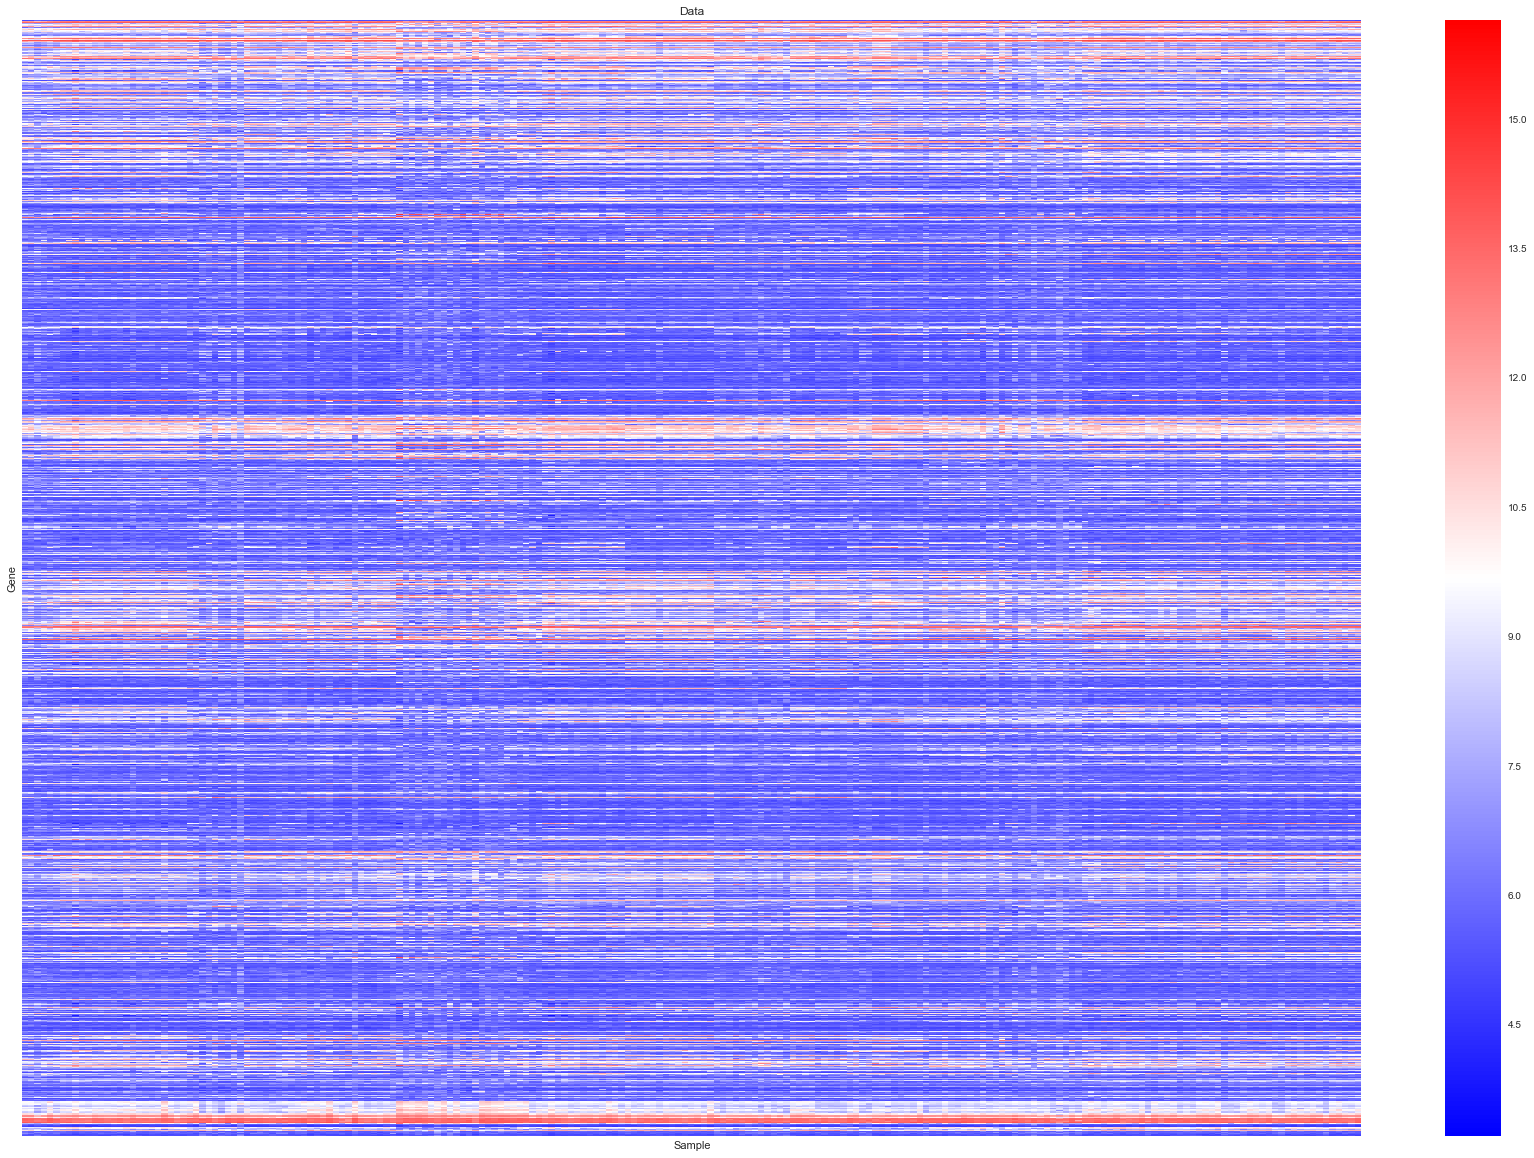

In [111]:
# Read gene expression matrix
gene_x_sample_df = pd.read_csv('./data/GES24759/GSE24759_series_matrix.txt', sep='\t', comment='!', index_col=0)
print('gene_x_sample_df shape: {}'.format(gene_x_sample_df.shape))

plt.figure(figsize=(30, 20))
ax = sns.heatmap(gene_x_sample_df, cmap='bwr', xticklabels=False, yticklabels=False)
ax.set(xlabel='Sample', ylabel='Gene')
ax.set_title('Data'.format(k))

In [3]:
# NMF and select k
KS = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]  # Ks from which to select k
nmf_results, scores = nmf_and_score(gene_x_sample_df, KS, method='cophenetic_correlation', verbose=True)
#nmf_results, scores = nmf_and_score(gene_x_sample_df, KS, method='intra_inter_ratio', verbose=True)

Computing clustering score for k=2 using method cophenetic_correlation ...
Computing the cophenetic correlation coefficient ...
Score for k=2: 0.7884401821498143
Computing clustering score for k=3 using method cophenetic_correlation ...
Computing the cophenetic correlation coefficient ...
Score for k=3: 0.7997762839846099
Computing clustering score for k=4 using method cophenetic_correlation ...
Computing the cophenetic correlation coefficient ...
Score for k=4: 0.7838031430141619
Computing clustering score for k=5 using method cophenetic_correlation ...
Computing the cophenetic correlation coefficient ...
Score for k=5: 0.7353152436869101
Computing clustering score for k=6 using method cophenetic_correlation ...
Computing the cophenetic correlation coefficient ...
Score for k=6: 0.7823668480082303
Computing clustering score for k=7 using method cophenetic_correlation ...
Computing the cophenetic correlation coefficient ...
Score for k=7: 0.7947281119154519
Computing clustering score f

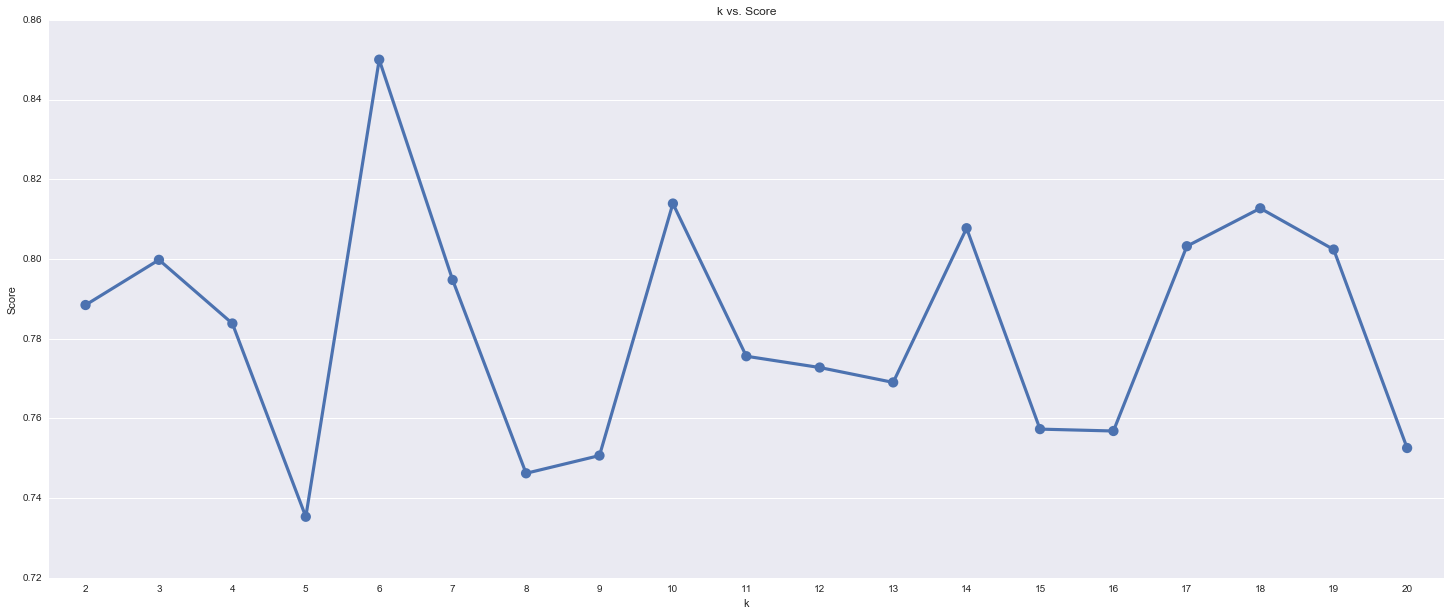

In [100]:
plot_nmf_scores(scores)

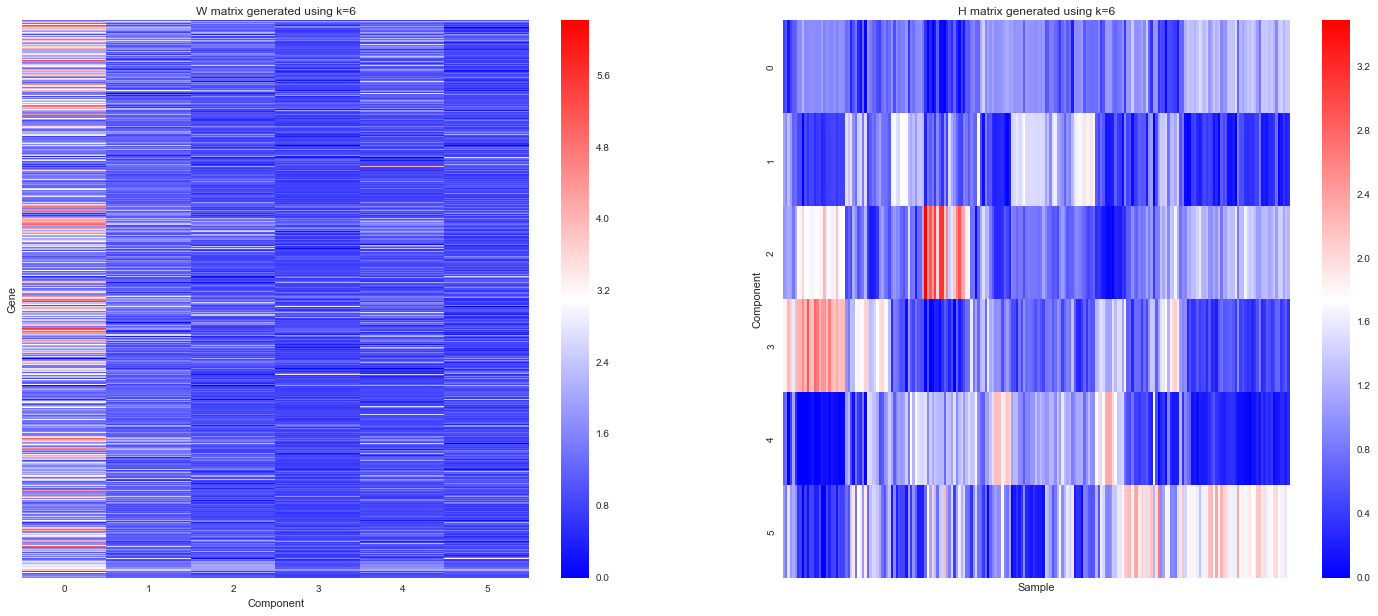

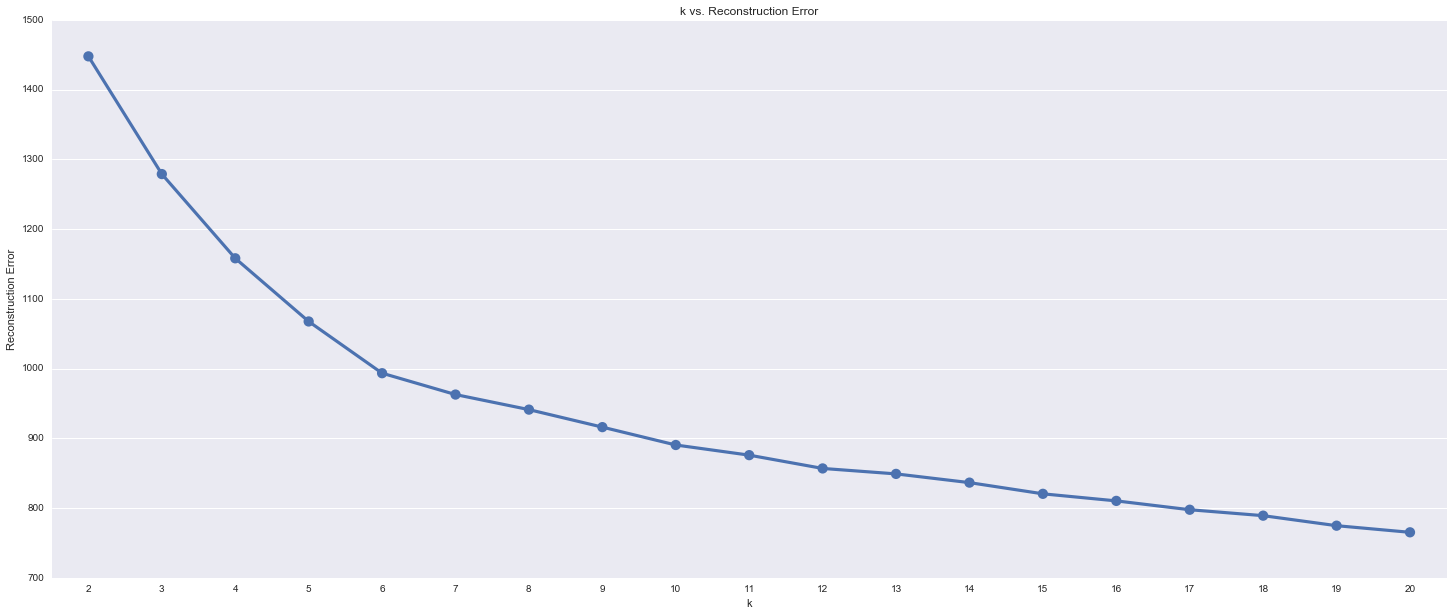

In [113]:
# Plot W and H matrices
k = 6
plot_nmf_result(nmf_results, 6)

In [7]:
# Get gene information
with open('./data/GES24759/GSE24759_family.soft') as f:
    gene_info = {}
    parse_errors = {}
    gene_symbol_errors = {}
    parse = False
    for i, line in enumerate(f.readlines()):
        line = line.strip()
        if not parse:
            if line == '!platform_table_begin':
                parse = True
                print('Start parsing at line {}'.format(i))
        else:
            if line == '!platform_table_end':
                print('Stop parsing at line {}'.format(i))
                parse = False
                break
            else:
                split = line.split('\t')
                try:
                    if (split[8] == '' or split[8] =='NA'):
                        gene_symbol_errors[split[0]] = line
                        continue
                    elif split[0] in gene_info:
                        print('Duplicate at {}'.format(split[0]))
                    else:
                        gene_info[split[0]] = {'gene_title':split[7],
                                               'gene_symbol':split[8].split(' /// '),
                                               'entrez_gene':split[9],
                                               'refseq':split[10].split(' /// ')}
                except:
                    parse_errors[split[0]] = line
    print('Parse error: {}'.format(len(parse_errors)))
    print('Gene symbol error {}'.format(len(gene_symbol_errors)))

Start parsing at line 277
Stop parsing at line 23223
Parse error: 1173
Gene symbol error 741


In [114]:
# TODO: figure out why the number of passing values are the same for other col in W
top_genes = {}  # dictionary(key:component; value:top genes)

percentile = 0.99
for i in range(nmf_results[k]['W'].shape[1]):
    name = 'k{}c{}'.format(k, i)
    print('Analyzing {} ...'.format(name))
    
    top_genes[name] = set()
    
    col = nmf_results[k]['W'][:, i]
    threshold = quantile(col, 100/((1-percentile)*100))[-1]
    indices_passing_threshold = np.nonzero(np.greater_equal(col, threshold)*col)[0]
    print('{} genes above {} percentile threshold.'.format(len(indices_passing_threshold), percentile*100))

    for gene in gene_x_sample_df.index[indices_passing_threshold]:
        if gene in gene_info:
            top_genes[name].update(set(gene_info[gene]['gene_symbol']))
        elif gene in parse_errors:
            print('Parse error at {}'.format(gene))
        elif gene in gene_symbol_errors:
            print('Gene symbol error at {}'.format(gene))
        else:
            print('Unknown error at {}'.format(gene))

Analyzing k6c0 ...
229 genes above 99.0 percentile threshold.
Parse error at 212560_at
Parse error at 212764_at
Parse error at 213158_at
Parse error at 215450_at
Parse error at 217554_at
Gene symbol error at HC-AL049987_at
Gene symbol error at HC-L41887_at
Gene symbol error at HC-M37033_at
Analyzing k6c1 ...
229 genes above 99.0 percentile threshold.
Gene symbol error at 212044_s_at
Parse error at 216246_at
Gene symbol error at HC-X76732_at
Analyzing k6c2 ...
229 genes above 99.0 percentile threshold.
Gene symbol error at HC-D87127_at
Analyzing k6c3 ...
229 genes above 99.0 percentile threshold.
Parse error at 213839_at
Parse error at 214836_x_at
Parse error at 215176_x_at
Parse error at 217257_at
Gene symbol error at HC-M37033_at
Analyzing k6c4 ...
229 genes above 99.0 percentile threshold.
Parse error at 213817_at
Analyzing k6c5 ...
229 genes above 99.0 percentile threshold.
Parse error at 208192_at
Parse error at 208529_at
Parse error at 211617_at
Parse error at 214809_at
Parse erro

In [115]:
for k, v in top_genes.items():
    print('\n\n*** {} ***'.format(k))
    for g in v:
        print('{}'.format(g))



*** k6c0 ***
HNRPH3
MGC8902
SACS
CBFB
AG1
ATR
GOLGA8B
GAPDS
RBM34
FNDC3A
RPL13
ANGEL2
MACF1
ZFP36L1
C14orf138
PIK3C2B
VDP
RPS14
ARHGEF6
MLLT11
IL2RG
IFI16
COIL
HINT1
FLJ38348
SLC5A3
IBTK
FLJ43663
HLA-C
MDFIC
PRDM2
RPS18
GPR171
FLJ20719
BTN3A3
ABLIM1
ADD3
CD69
RPL13A
GARNL1
TRBC1
TRIM22
ACSL5
PRKD3
ZNF292
SMURF2
RASGRP1
LY75
ZBTB20
TARBP1
SFRS12
SMCHD1
ZFP36L2
POLS
Septin 6
KIAA0528
FLJ20436
RPL3
MGA
ZNF14
NOTCH2
SFRS7
LEPROTL1
NARG1L
TRBV5-4
DHX15
THUMPD1
LOC94431
ATM
PRPF4B
DYRK2
C6orf48
MTMR1
ITM2A
CXorf45
GIMAP5
SMARCA2
TRBV21-1
RUNX1
ABCC1
HMGN4
LYRIC
LOC93349
FLJ20485
HNRPD
PTGER4
FAM62A
TES
C6orf111
NKTR
RPS19
TRIB2
DC36
SFRS5
DDX47
PSIP1
GLTSCR2
RYK
SLC4A7
PFAAP5
TGFBRAP1
TRAF3IP3
IPO7
PBP
TGFBR2
RABL2A
KIAA1128
TARDBP
DKFZp686P0288
FNBP1
CD48
SERPINB9
MDN1
PORIMIN
LOC375258
LPIN1
CD53
RAPGEF6
MKL2
TTC3
BTN3A1
TORC3
ITPKB
PRKACB
SHQ1
MYCBP2
LOC200030
TNPO1
PTBP2
LDHB
SELL
SLC7A6
TRBV3-1
PTPRC
MRPS6
NPM1
SLC38A1
TRAF5
RANBP2L1
ZNF395
ZMYND11
RABL2B
PDE4D
FBL
DICER1
LOC440675
SN